In [39]:
import os,time
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

%run update_path_to_download_script
# from downloaddata import fetch_data as fdata

# from downloaddata import fetch_data_all
import numpy as np

import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *

inputDir = '../data/train'
outputDir = 'output'

ERROR:root:File `'update_path_to_download_script.py'` not found.


In [40]:
def myshow(img, title=None, margin=0.05, dpi=100):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (4 + margin) * ysize / dpi, (4 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
   
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [41]:
def loadData( inputDir, padding=0 ):
    imageflairFilenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","FLAIR.nii.gz"))
#     imageT1Filenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","T1.nii.gz"))
    labelFilenames= glob.glob(os.path.join(inputDir, "Utrecht", "*","wmh.nii.gz"))
    images = None # shape: (numImages, z, y, x, channels=1)
    labels = None
    masks  = None
    
    for imageflairFilenames, labelFilenames in zip(imageflairFilenames, labelFilenames):
        # Load the images
        flairImage = sitk.ReadImage(imageflairFilenames)
#         T1Image = sitk.ReadImage(imageT1Filenames)
        labelImage = sitk.ReadImage(labelFilenames)
        # Convert to arrays
        flairArray = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
#         T1Array = np.pad(sitk.GetArrayFromImage(T1Image), [(0,0),(padding,padding),(padding,padding)], 'constant')
        labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        maskArray = labelArray > 0
        
        # Add to the images/labels array
        if images is None:
            images = flairArray.reshape([1] + list(flairArray.shape) + [1])
#             images = np.concatenate([images, T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            labels = labelArray.reshape([1] + list(labelArray.shape) + [1])
            masks  = maskArray.reshape([1] + list(maskArray.shape) + [1])
        else:
            tempArray = np.concatenate([flairArray.reshape([1] + list(flairArray.shape) + [1])], axis=4)
            
            images = np.concatenate([images, tempArray])
            
            labels = np.concatenate([labels, labelArray.reshape([1] + list(labelArray.shape) + [1])])
            masks  = np.concatenate([masks, maskArray.reshape([1] + list(maskArray.shape) + [1])])
                    
    return images, labels, masks

In [42]:
testImages, testLabels, testMasks = loadData(inputDir)
testNonZeroIdx = np.nonzero(testMasks)

In [43]:
X = np.asarray(testImages[10])
y = np.asarray(testLabels[10])
print(X.shape, X.min(), X.max()) # (240, 240, 4) -0.380588 2.62761
print(y.shape, y.min(), y.max()) # (240, 240, 1) 0 1 

(48, 240, 240, 1) 0.0 3179.9204
(48, 240, 240, 1) 0.0 2.0


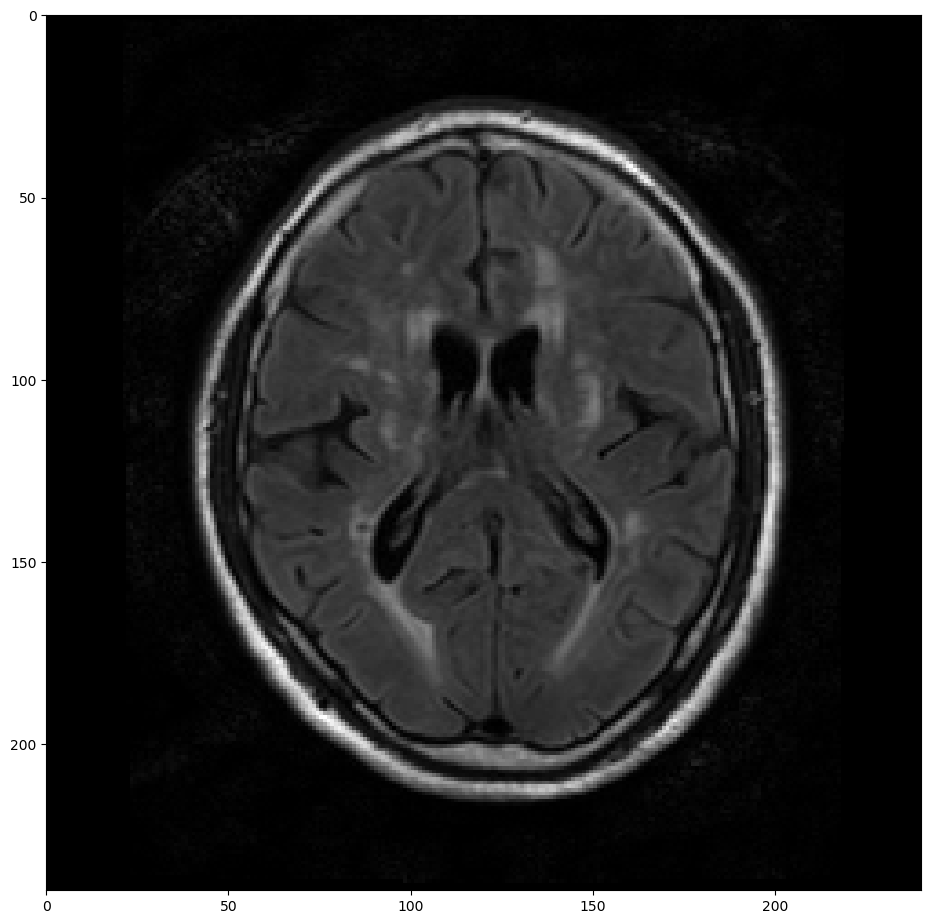

In [44]:
myshow(sitk.GetImageFromArray(X))

In [45]:

from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [46]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [47]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [48]:
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    print(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i,:,:], (img_cols, img_rows), preserve_range=True)
        print("imgs_p[i]",imgs_p[i],imgs_p[i].shape)
    imgs_p = imgs_p[..., np.newaxis]
    
    print("imgs_p",imgs_p.shape)
    return imgs_p

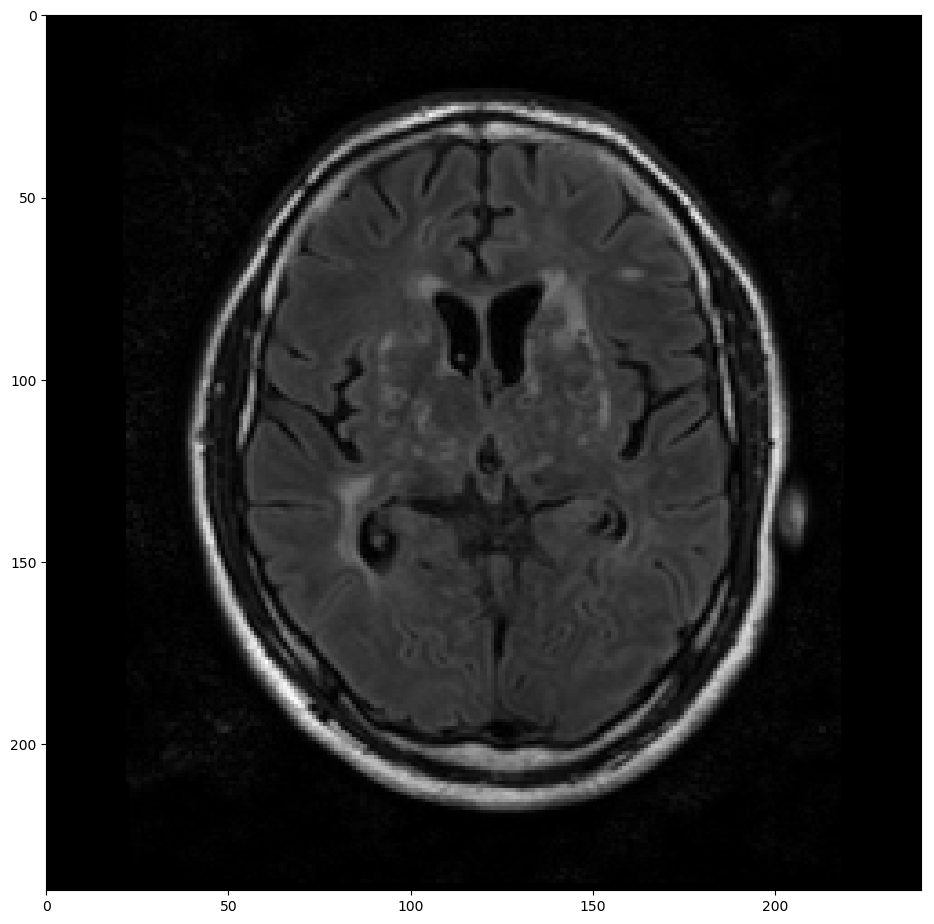

In [49]:
myshow(sitk.GetImageFromArray(X[20:22,:,:,0]))

In [50]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = X[20:22,:,:,0], y[20:22,:,:,0]#load_train_data()
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,0]))
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,1]))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("shape",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)
    print("shape",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
#     myshow(sitk.GetImageFromArray(imgs_train))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
    model.fit(imgs_train, imgs_mask_train, batch_size=8, nb_epoch=5, verbose=0, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    
    
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_id_test = X[30:31,:,:,0], y[30:31,:,:,0]
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    myshow(sitk.GetImageFromArray(imgs_test))
    myshow(sitk.GetImageFromArray(imgs_mask_test))
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, imgs_id_test):
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir, "image_id" + '_pred.png'), image)

In [51]:
img_rows = 512
img_cols = 512

smooth = 1.

------------------------------
Loading and preprocessing train data...
------------------------------
(2, 240, 240)


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  down-scaling factor.


imgs_p[i] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (512, 512)
imgs_p[i] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (512, 512)
imgs_p (2, 512, 512, 1)
(2, 240, 240)
imgs_p[i] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (512, 512)
imgs_p[i] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (512, 512)
imgs_p (2, 512, 512, 1)
shape (2, 512, 512, 1) (2, 512, 512, 1)
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


------------------------------
Loading and preprocessing test data...
------------------------------
(1, 240, 240)
imgs_p[i] [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (512, 512)
imgs_p (1, 512, 512, 1)
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
1/1 [==============================] - 2s 2s/step
------------------------------
Saving predicted masks to files...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\io\_io.py:132: UserWarning: preds\image_id_pred.png is a low contrast image
  where 1 is worst quality and smallest file size, and 100 is best quality


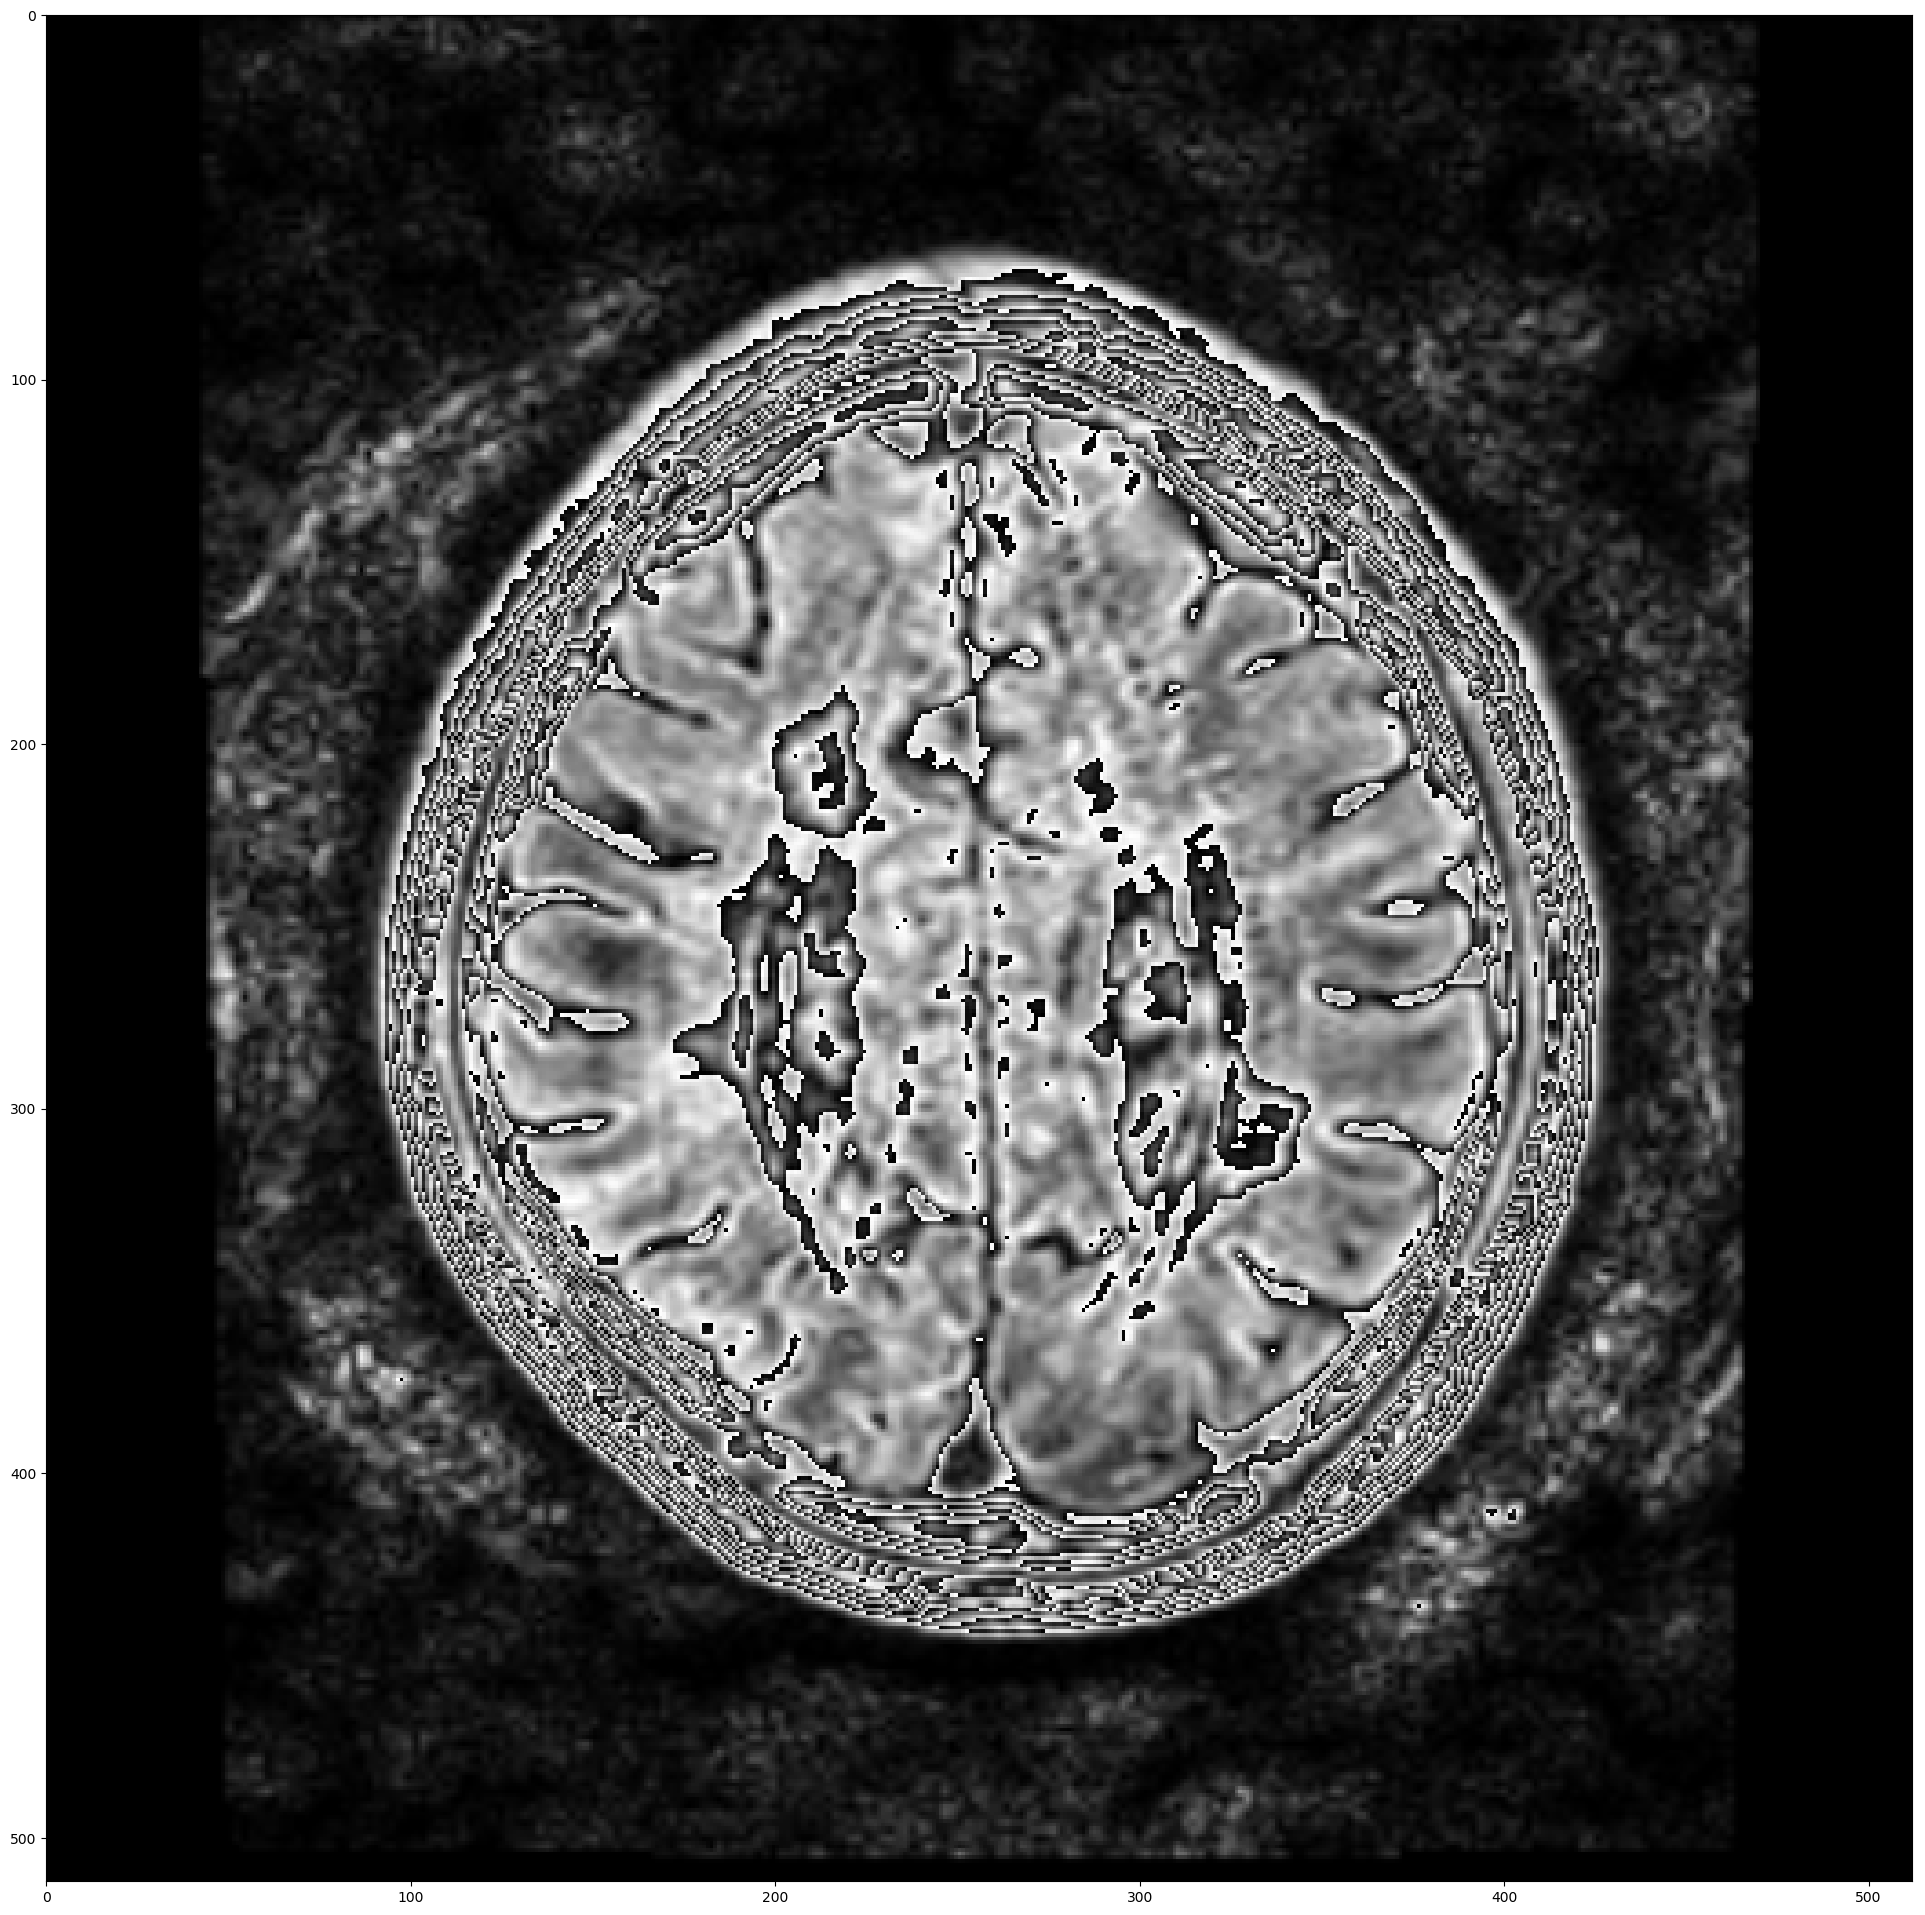

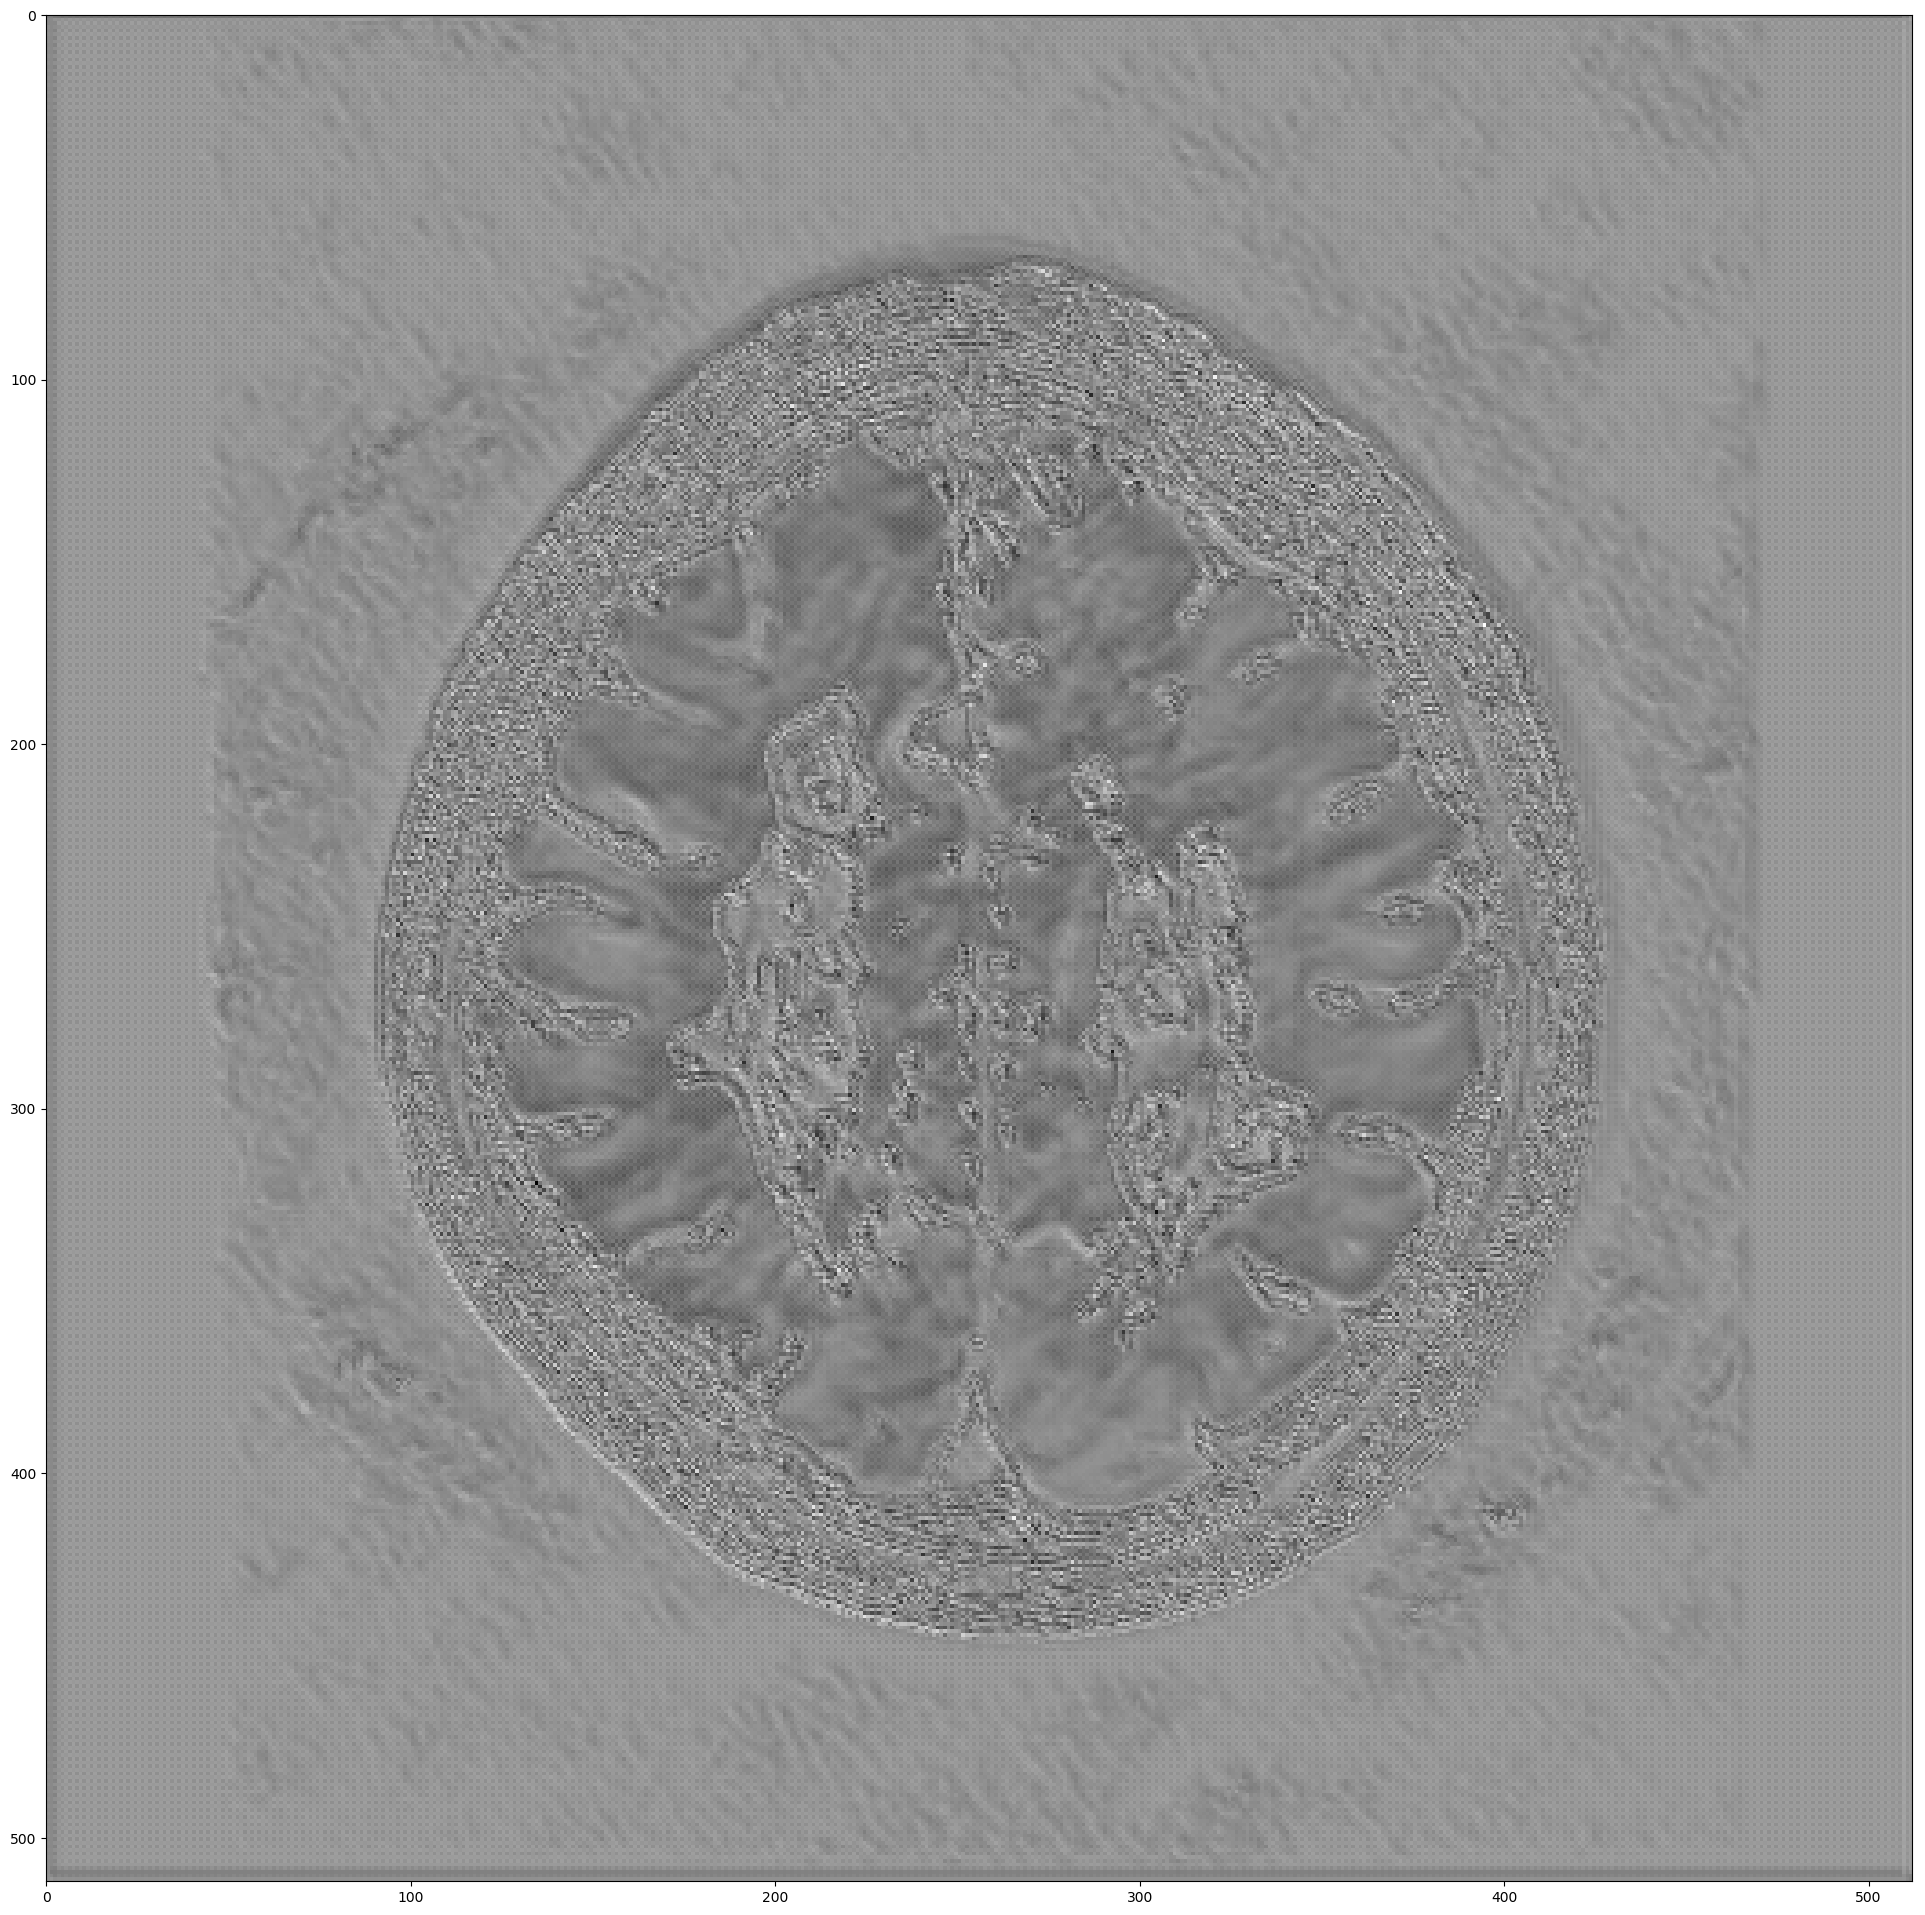

In [52]:
if __name__ == '__main__':
    train_and_predict()